# Laboratorio 1: Regresión en Boston

En este laboratorio deben hacer experimentos de regresión con el conjunto de datos "Boston house prices dataset".

Estudiarán el dataset, harán visualizaciones y seleccionarán atributos relevantes a mano.

Luego, entrenarán y evaluarán diferentes tipos de regresiones, buscando las configuraciones que mejores resultados den.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Carga del Conjunto de Datos

Cargamos el conjunto de datos y vemos su contenido.

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [3]:
print(boston['DESCR'])   # descripción del dataset
# boston['data']           # matriz con los datos de entrada (atributos)
# boston['target']         # vector de valores a predecir
# boston['feature_names']  # nombres de los atributos para cada columna de 'data'

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
boston['data'].shape, boston['target'].shape

((506, 13), (506,))

## División en Entrenamiento y Evaluación

Dividimos aleatoriamente los datos en 80% para entrenamiento y 20% para evaluación:

In [5]:
from sklearn.model_selection import train_test_split
X, y = boston['data'], boston['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((404, 13), (102, 13))

## Ejercicio 1: Descripción de los Datos y la Tarea

Responda las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponibles para hacer la predicción?
4. ¿Qué atributos imagina ud. que serán los más determinantes para la predicción?
5. ¿Qué problemas observa a priori en el conjunto de datos? ¿Observa posibles sesgos, riesgos, dilemas éticos, etc? Piense que los datos pueden ser utilizados para hacer predicciones futuras.

**No hace falta escribir código para responder estas preguntas.**

**Responder todas las preguntas acá.**

1.- El conjunto de datos contiene informacion obtenida por el servicio de censo de los Estados Unidos, en el area de Boston, Massachussets.

2.- La variable objetivo a predecir es el atributo en la posicion 14, MEDV, que es el valor de la mediana del precio de las casas obtenidas en el censo.

3.- Poseemos los siguientes atributos para realizar una prediccion:

Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        
4.- A priori podemos intuir que los siguientes atributos seran los mas importantes para la prediccion:

        - RM
        - TAX
        - CRIM
        
5.- El unico problema que se observa a priori es el sesgo racial que es determinado por el atributo B (1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town), el cual dicta la proporcion de personas de raza negra.


## Ejercicio 2: Visualización de los Datos

1. Para cada atributo de entrada, haga una gráfica que muestre su relación con la variable objetivo.
2. Estudie las gráficas, identificando **a ojo** los atributos que a su criterio sean los más informativos para la predicción.
3. Para ud., ¿cuáles son esos atributos? Lístelos en orden de importancia.

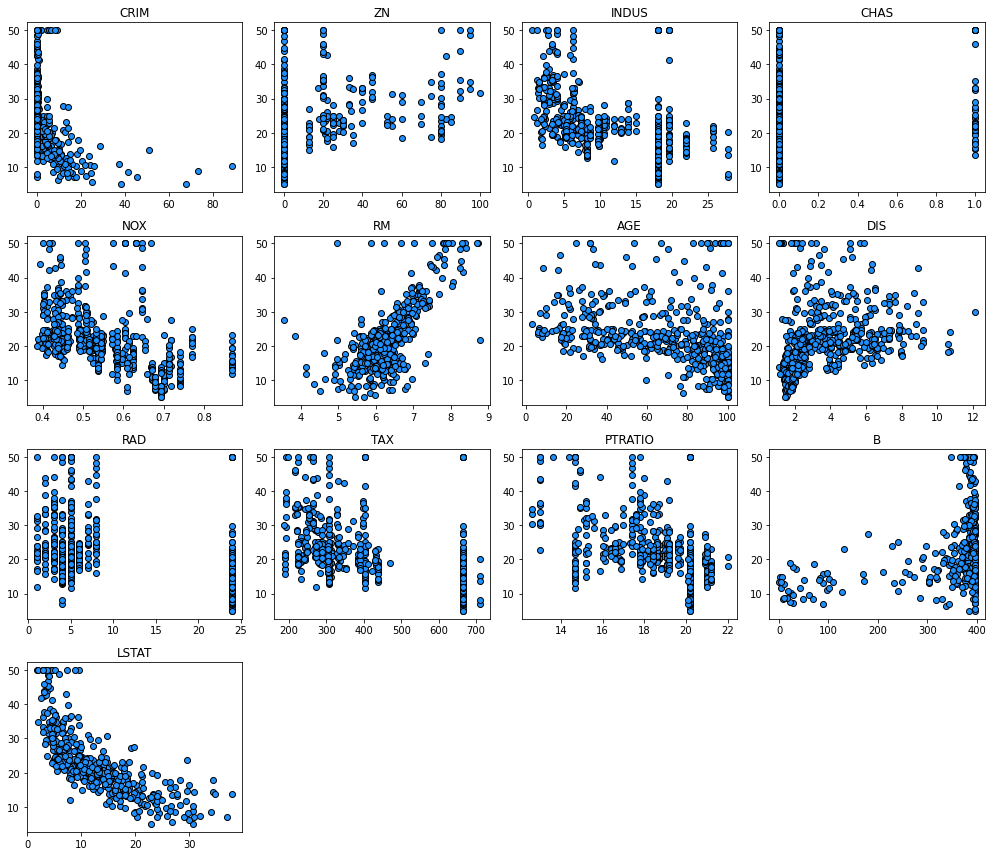

In [6]:
# 1. Resolver acá. Ayuda/ejemplo:
fig = plt.figure(figsize=(14,12))
#feature = 'CRIM'
for n, feature in zip(range(1, len(boston['feature_names'])+1), boston['feature_names']):
    selector = (boston['feature_names'] == feature)
    ax = fig.add_subplot(4,4,n)
    ax.scatter(X[:, selector], y, facecolor="dodgerblue", edgecolor="k", label="datos")
    ax.set_title(feature)

plt.tight_layout()
plt.show()

In [7]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['MEDV'] = boston.target

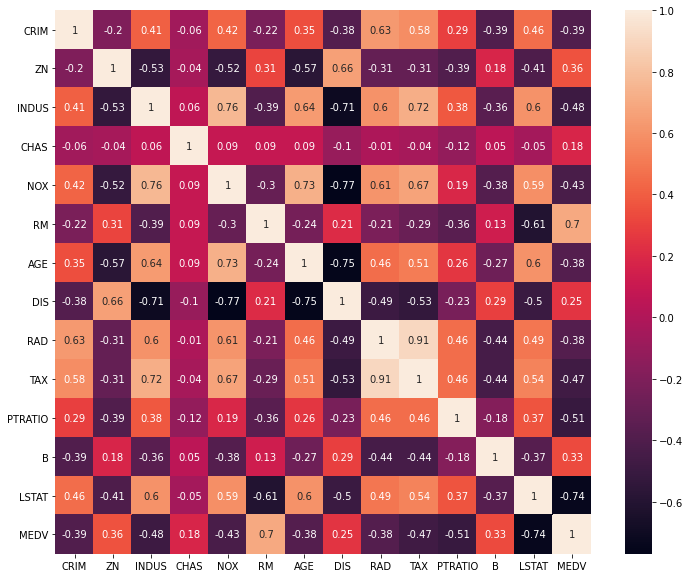

In [8]:
plt.figure(figsize=(12,10))
corr = boston_df.corr().round(2)
sns.heatmap(data=corr, annot=True)

Analizando las gráficas a ojo, se puede ver que las variables que mayor relación presentan con la variable objetivo son LSTAT (Porcentaje de población de “estatus de bajo nivel”) y 
RM (Número promedio de habitaciones por vivienda) siendo dichos atributos los más importantes en ese orden. Otro de los atributos que también presenta relación con la variable objetivo es
AGE (Proporción de viviendas en propiedad ocupadas, construidas antes de 1940).

**2. Responder acá**
En base a las graficas scatterplot y a la matriz de correlacion, podemos ver alta correlacion entre MEDV y los atributos RM y LSTAT

**3. Responder acá**
Los atributos seleccionados en orden de importancia son:
    - LSTAT    % lower status of the population
    - RM       average number of rooms per dwelling

## Ejercicio 3: Regresión Lineal

1. Seleccione **un solo atributo** que considere puede ser el más apropiado.
2. Instancie una regresión lineal de **scikit-learn**, y entrénela usando sólo el atributo seleccionado.
3. Evalúe, calculando error cuadrático medio para los conjuntos de entrenamiento y evaluación.
4. Grafique el modelo resultante, junto con los puntos de entrenamiento y evaluación.
5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

**Observación:** Con algunos atributos se puede obtener un error en test menor a 50.

In [9]:
# 1. Resolver acá. Ayuda:
feature = 'LSTAT'  # selecciono el atributo 'CRIM'
selector = (boston['feature_names'] == feature)
X_train_f = X_train[:, selector]
X_test_f = X_test[:, selector]
X_train_f.shape, X_test_f.shape

((404, 1), (102, 1))

In [10]:
# 2. Instanciar y entrenar acá.
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_f, y_train)

LinearRegression()

In [11]:
# 3. Predecir y evaluar acá.
from sklearn.metrics import mean_squared_error

y_train_pred = model.predict(X_train_f)
y_test_pred = model.predict(X_test_f)

In [12]:
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)
print(f'Train error: {round(train_error, 2)}')
print(f'Test error: {round(test_error, 2)}')

Train error: 36.52
Test error: 46.34


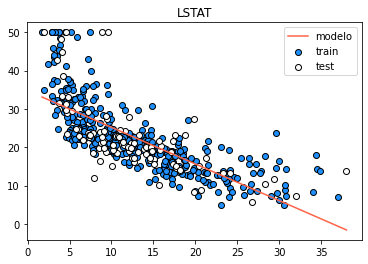

In [13]:
# 4. Graficar acá. Ayuda:
x_start = min(np.min(X_train_f), np.min(X_test_f))
x_end = max(np.max(X_train_f), np.max(X_test_f))
x = np.linspace(x_start, x_end, 200).reshape(-1, 1)
plt.plot(x, model.predict(x), color="tomato", label="modelo")

plt.scatter(X_train_f, y_train, facecolor="dodgerblue", edgecolor="k", label="train")
plt.scatter(X_test_f, y_test, facecolor="white", edgecolor="k", label="test")
plt.title(feature)
plt.legend()
plt.show()

**5. Responder acá**

El modelo lineal reproduce el comportamiento de la variable 'LSTAT' moderadamente bien. Podemos ver que los valores de y_train se alejan considerablemente de la recta cuando 5>X_train>30, aproximadamente. Este comportamiento también se observa pra los datos de test. Además, se observa que el MSE para los datos del conjunto de test es mayor que para el conjunto de entrenamiento, debido a que los valores de la variable objetivo MDEV se alejan en mayor medida de la recta predicha.
Por lo tanton necesitamos un modelo polinomial para ajustar mejor los datos. 

## Ejercicio 4: Regresión Polinomial

En este ejercicio deben entrenar regresiones polinomiales de diferente complejidad, siempre usando **scikit-learn**.

Deben usar **el mismo atributo** seleccionado para el ejercicio anterior.

1. Para varios grados de polinomio, haga lo siguiente:
    1. Instancie y entrene una regresión polinomial.
    2. Prediga y calcule error en entrenamiento y evaluación. Imprima los valores.
    3. Guarde los errores en una lista.
2. Grafique las curvas de error en términos del grado del polinomio.
3. Interprete la curva, identificando el punto en que comienza a haber sobreajuste, si lo hay.
4. Seleccione el modelo que mejor funcione, y grafique el modelo conjuntamente con los puntos.
5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

**Observación:** Con algunos atributos se pueden obtener errores en test menores a 40 e incluso a 35.

1. Para varios grados de polinomio, haga lo siguiente:
    1. Instancie y entrene una regresión polinomial.
    2. Prediga y calcule error en entrenamiento y evaluación. Imprima los valores.
    3. Guarde los errores en una lista.

In [14]:
#Entrenamos con distintos grados de polinomino e imprimimos aquellos que tienen un error cuadrático menor a 40
train_errors = []
test_errors = []

degrees = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for degree in degrees: 
  from sklearn.preprocessing import PolynomialFeatures

train_errors = []
test_errors = []
degrees = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for degree in degrees:
    # train:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_f, y_train);
    
    # predict:
    y_train_pred = model.predict(X_train_f)
    y_test_pred = model.predict(X_test_f)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    #print
    if test_error < 40:
        print(f'Degree: {degree}' )
        print(f'Train error: {train_error:0.4}')
        print(f'Test error: {test_error:0.4}')

Degree: 2
Train error: 28.19
Test error: 38.85
Degree: 3
Train error: 26.78
Test error: 37.22
Degree: 4
Train error: 25.85
Test error: 34.7
Degree: 5
Train error: 25.03
Test error: 34.83
Degree: 6
Train error: 25.01
Test error: 34.33
Degree: 7
Train error: 25.01
Test error: 34.26
Degree: 8
Train error: 24.85
Test error: 36.41
Degree: 9
Train error: 24.83
Test error: 34.94


2. Grafique las curvas de error en términos del grado del polinomio.

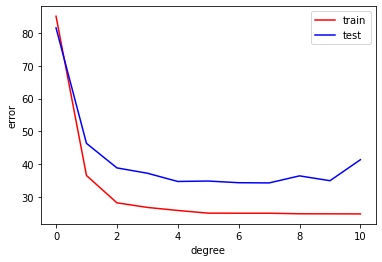

In [15]:
# 2. Graficamos curvas de error.
plt.plot(degrees, train_errors, color="red", label="train")
plt.plot(degrees, test_errors, color="blue", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

In [16]:
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print(f'Train error: {train_error:0.4}')
print(f'Test error: {test_error:0.4}')

Train error: 24.8
Test error: 41.35


3. Interprete la curva, identificando el punto en que comienza a haber sobreajuste, si lo hay.

El grado que minimiza el error en test se encuentra a partir del grado 2 y se encuentran errores similares hasta el grado de polinomio 9. El grado 7 es el que tiene el error en test mínimo. A partir del grado de polinomio mayor a 9 comienza a haber sobreajuste. Tambien podemos indicar que polinomios de menor grado a 2 no son adecuados de acuerdo a los valores de error observados. 

4. Seleccione el modelo que mejor funcione, y grafique el modelo conjuntamente con los puntos.

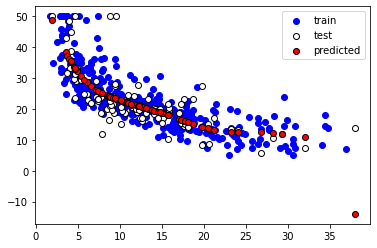

In [17]:
# 4. Reconstruir mejor modelo acá y graficar.
degree = 7
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_f, y_train);

plt.scatter(X_train_f, y_train, color="blue", label="train")
plt.scatter(X_test_f, y_test, color="white", edgecolor="k", label="test")
plt.scatter(X_test_f, y_test_pred, facecolor="red", edgecolor="k", label="predicted")
#plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.legend()
plt.show()

5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

Se observa que con un grado de polinomio de 7 se obtiene la función que minimiza el error cuadrático para el atributo LSTAT. Se observa cierta dispersión entre el modelo y los puntos de entrenamiento y test. Entendemos que existen outliers que deberían ser tratados antes de volver a entrenar el algoritmo de manera de que el modelo represente mejor la curva de los datos. 

## Ejercicio 5: Regresión con más de un Atributo

En este ejercicio deben entrenar regresiones que toman más de un atributo de entrada.

1. Seleccione **dos o tres atributos** entre los más relevantes encontrados en el ejercicio 2.
2. Repita el ejercicio anterior, pero usando los atributos seleccionados. No hace falta graficar el modelo final.
3. Interprete el resultado y compare con los ejercicios anteriores. ¿Se obtuvieron mejores modelos? ¿Porqué?

In [18]:
# 1. Resolver acá. Ayuda (con dos atributos):
selector = (boston['feature_names'] == 'LSTAT') | (boston['feature_names'] == 'RM')
X_train_fs = X_train[:, selector]
X_test_fs = X_test[:, selector]
X_train_fs.shape, X_test_fs.shape

((404, 2), (102, 2))

In [19]:
# 2. Resolver acá.

train_errors_fs = []
test_errors_fs = []
degrees = [1, 2, 3, 4, 5, 6, 7]
for degree in degrees:
    # train:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_fs, y_train)
    
    # predict:
    y_train_pred_fs = model.predict(X_train_fs)
    y_test_pred_fs = model.predict(X_test_fs)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred_fs)
    test_error = mean_squared_error(y_test, y_test_pred_fs)
    train_errors_fs.append(train_error)
    test_errors_fs.append(test_error)

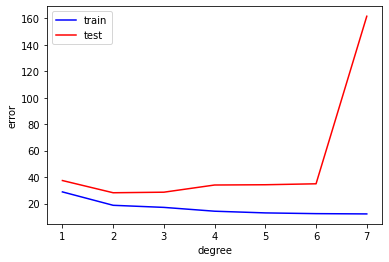

In [20]:
plt.plot(degrees, train_errors_fs, color="blue", label="train")
plt.plot(degrees, test_errors_fs, color="red", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

In [21]:
# Reconstruir mejor modelo acá y graficar.

degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_fs, y_train)

# predict:
y_train_pred_fs = model.predict(X_train_fs)
y_test_pred_fs = model.predict(X_test_fs)

# evaluate:
train_error = mean_squared_error(y_train, y_train_pred_fs)
test_error = mean_squared_error(y_test, y_test_pred_fs)
print(f'Train error: {round(train_error, 2)}')
print(f'Test error: {round(test_error, 2)}')

Train error: 18.66
Test error: 28.14


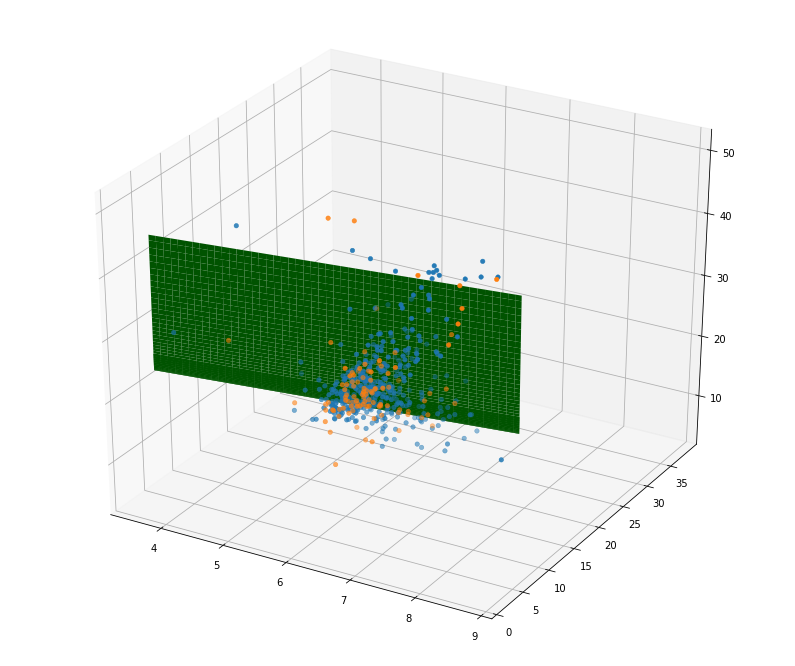

In [22]:
x_start_fs = min(np.min(X_train_fs[:, 0]), np.min(X_test_fs[:, 0]))
x_end_fs = max(np.max(X_train_fs[:, 0]), np.max(X_test_fs[:, 0]))
y_start_fs = min(np.min(X_train_fs[:, 1]), np.min(X_test_fs[:, 1]))
y_end_fs = max(np.max(X_train_fs[:, 1]), np.max(X_test_fs[:, 1]))
x_fs = np.linspace(x_start_fs, x_end_fs, 400).reshape(-1, 2)

fig = plt.figure(figsize=(14,12))
ax = plt.axes(projection='3d')
ax.scatter(X_train_fs[:, 0], X_train_fs[:, 1], y_train, linewidth=0.5)
ax.scatter(X_test_fs[:, 0], X_test_fs[:, 1], y_test, linewidth=0.5)
ax.plot_surface(x_fs[:, 0], x_fs[:, 1], model.predict(x_fs).reshape(-1,1), color='green')


Se observa que cuando utilizamos dos features el error de entrenamiento baja de 24.8 a 18.66, lo cual es una ganancia considerable. Para el caso del conjunto de test la disminución del error es de 41.35 a 28.14

## Más ejercicios (opcionales)

### Ejercicio 7: A Todo Feature

Entrene y evalúe regresiones pero utilizando todos los atributos de entrada (va a andar mucho más lento). Estudie los resultados.



In [23]:
X_train.shape, X_test.shape

((404, 13), (102, 13))

In [24]:
train_errors_all = []
test_errors_all = []
degrees = [1, 2]
for degree in degrees:
    # train:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict:
    y_train_pred_all = model.predict(X_train)
    y_test_pred_all = model.predict(X_test)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred_all)
    test_error = mean_squared_error(y_test, y_test_pred_all)
    train_errors_all.append(train_error)
    test_errors_all.append(test_error)

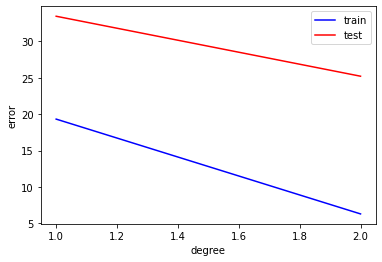

In [25]:
plt.plot(degrees, train_errors_all, color="blue", label="train")
plt.plot(degrees, test_errors_all, color="red", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

In [26]:
degree = 2

model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

# predict:
y_train_pred_all = model.predict(X_train)
y_test_pred_all = model.predict(X_test)

# evaluate:
train_error = mean_squared_error(y_train, y_train_pred_all)
test_error = mean_squared_error(y_test, y_test_pred_all)
print(f'Train error: {round(train_error, 2)}')
print(f'Test error: {round(test_error, 2)}')

Train error: 6.31
Test error: 25.22


Se observa que cuando incluimos todas las features el error de entrenamiento disminuye considerablemente de 18.66 (con dos features) a 6.31. De manera similar, el MSE de test disminuye aunque lo hace en menor medida de 28.14 a 25.22. Por lo tanto, en este caso utilizar todas las features presenta una ventaja considerable al reducir el error en el conjunto de entrenamiento y de manera moderada en el conjunto de test.

### Ejercicio 8: Regularización

Entrene y evalúe regresiones con regularización "ridge". Deberá probar distintos valores de "alpha" (fuerza de la regularización). ¿Mejoran los resultados?


In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import ParameterGrid

In [28]:
param_grid = {
    'alpha': [1e-4,1e-3,1e-2,1e-1,1e-0],
}

In [29]:
train_errors = []
test_errors = []
degree = 2

for params in ParameterGrid(param_grid):
    # train:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(**params,normalize=True))
    model.fit(X_train, y_train)
    
    # predict:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

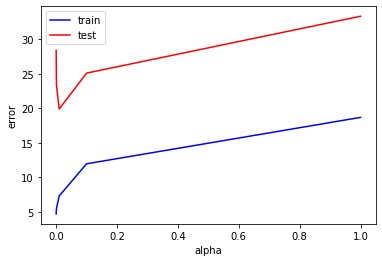

In [30]:
plt.plot(param_grid['alpha'], train_errors, color="blue", label="train")
plt.plot(param_grid['alpha'], test_errors, color="red", label="test")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("error")
plt.show()

In [31]:
degree = 2
alpha = 1e-3

model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha, normalize=True))
model.fit(X_train, y_train)

# predict:
y_train_pred_all = model.predict(X_train)
y_test_pred_all = model.predict(X_test)

# evaluate:
train_error = mean_squared_error(y_train, y_train_pred_all)
test_error = mean_squared_error(y_test, y_test_pred_all)
print(f'Train error: {round(train_error, 2)}')
print(f'Test error: {round(test_error, 2)}')

Train error: 5.49
Test error: 23.39


Al incluir el modelo Ridge y seleccionar el valor de alpha adecuado logramos reducir el MSE del conjunto de entrenamiento en 0.82 y el conjunto de test en casi 2 puntos. Podemos ver que la regresión Ridge presenta ventajas sobre la regresióón polinomial usual.